## Scaling with LO

In this notebook, we consider the simulation of a period chain of qubits. Due to the periodic nature of this problem, for most practical purposes, it requires a 2-qubit operation between two ends of the hardware topology -- which leads to a significant number of SWAP gates. In this notebook we show the usage of gate cutting to deal with such a problem. In summary, gate cutting can be incorporated to logically calculate the long distance 2-qubit operations. In other words, gate cutting approach effectively leads to an increase in the connectivity of the coupling map. Naturally, this leads to a significant lowering of SWAP gates, leading to improved performance.

For more details on gate cutting, and circuit knitting in general, refer to <a href='https://qiskit-extensions.github.io/circuit-knitting-toolbox/index.html'>circuit-knitting-toolbox</a> and the related tutorials.

In this notebook with show the effect of cutting a single periodic chain of an MBL type circuit and show the improvement it offers without any error mitigation or suppresion techniques.

### 1. Map circuit to quantum hardware native form

For this study we consider a compute-uncompute MBL-like periodic chain. This is the MBL circuit with a periodic 2-qubit operation connecting the last qubit to the first one. MBL is a hardware-friendly circuit, i.e., it doesn't require SWAP gates for mapping it to the underlying hardware. However, it is the periodic 2-qubit operation which is costly.

A compute-uncompute circuit appends the inverse of the circuit unitary to the circuit, so that ideally the outcome is $|0\rangle^n$, $n$ being the number of qubits. Having a compute-uncompute circuit removes the need of simulating the ideal outcome for verification. However, a depth k (must be even) MBL-like periodic chain requires k/2 gate cuts. But, when we use the compute-uncompute version, it doubles the number of cuts required.

In [1]:
from numpy import pi, concatenate
from numpy.random import default_rng
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector

def build_random_spin_chain_circuit(
        num_qubits: int, imbalance: int = 0, *, seed: int | None = None
    ) -> QuantumCircuit:
    """Build quantum circuit preparing a random spin chain in the computational basis.
    Args:
        num_qubits: number of qubits (needs to be even).
        imbalance: imbalance between the number of excited sites and the
            number of unexcited sites from the reference anti-ferromagnetic
            state. Positive (negative) means more (un)excited states.
        seed: to randomly choose excitations.
    Returns: 
        A computational basis state quantum circuit representing a random spin chain.
    """
    if num_qubits % 2 != 0:
        raise ValueError("Number of qubits must be even.")
    if abs(imbalance) > (num_qubits // 2):
        raise ValueError("Imbalance (abs) cannot exceed half the total number of qubits.")

    rng = default_rng(seed)
    even_qubits = rng.permutation(range(0, num_qubits, 2))
    odd_qubits = rng.permutation(range(1, num_qubits, 2))
    num_excitations = (num_qubits // 2) + imbalance
    excited_qubits = concatenate((even_qubits, odd_qubits))[:num_excitations]
    
    circuit = QuantumCircuit(num_qubits)
    for qubit in excited_qubits:
        circuit.x(qubit)
    return circuit


def build_periodic_mbl_evolution_circuit(
        num_qubits: int, depth: int, *, barriers: bool = False
    ) -> QuantumCircuit:
    """Build parameterized MBL evolution quantum circuit.
    
    Args:
        num_qubit: number of qubits.
        depth: two-qubit depth.
        barriers: if True adds barriers between layers.
    Returns:
        An MBL evolution quantum circuit with regime parameter θ,
        and disorders' parameter-vector φ.
    """
    if num_qubits <= 2:
        raise ValueError("Number of qubits must be greater than two.")
    if num_qubits % 2 != 0:
        raise ValueError("Number of qubits must be even.")
    
    theta = Parameter('θ') 
    phis = ParameterVector('φ', num_qubits)
    circuit = QuantumCircuit(num_qubits)

    for layer in range(depth):
        layer_parity = layer % 2
        if barriers:
            circuit.barrier()
        for qubit in range(layer_parity, num_qubits - 1, 2):
            circuit.cz(qubit, qubit + 1)
            circuit.u(theta, 0, pi, qubit)
            circuit.u(theta, 0, pi, qubit + 1)
        if layer_parity == 1:
            circuit.cz(num_qubits-1,0)
            circuit.u(theta, 0, pi, num_qubits-1)
            circuit.u(theta, 0, pi, 0)
        for qubit in range(num_qubits):
            circuit.p(phis[qubit], qubit)
    
    return circuit


def build_compute_uncompute_mbl_circuit(
        num_qubits: int, 
        depth: int, 
        imbalance: int = 0,
        measurements: bool = True, 
        barriers: bool = False, 
        seed: int | None = None,
    ) -> QuantumCircuit:
    """Build a parametrized compute-uncompute MBL quantum circuit."""
    if depth % 2 != 0:
       raise ValueError("Depth must be even.")

    initial_state = build_random_spin_chain_circuit(num_qubits, imbalance, seed=seed)
    evolution = build_periodic_mbl_evolution_circuit(num_qubits, depth, barriers=barriers)
    
    circuit = QuantumCircuit(num_qubits)
    circuit.compose(initial_state, inplace=True)
    circuit.compose(evolution, inplace=True)
    circuit.barrier()
    circuit.compose(evolution.inverse(), inplace=True)
    circuit.compose(initial_state.inverse(), inplace=True)
    if measurements:
        circuit.measure_all(inplace=True)
    
    return circuit


def produce_mbl_parameters(interaction_strength, num_qubits, *, seed=None):
    """Produce MBL parameters.
    Args:
        interaction_strength: the strength of interaction relative to pi.
            For a 1D chain the critical strength separating the MBL and
            thermal/ergodic regimes is found to be approximately 0.16 [1].
        num_qubits: the number of qubits.
        seed: a seed to generate the random disorders.
    Returns:
        A tuple holding the interaction angle theta, and the disorders phis.
    Notes:
        [1] Shtanko et.al. Uncovering Local Integrability in Quantum
            Many-Body Dynamics, https://arxiv.org/abs/2307.07552
    """
    rng = default_rng(seed=seed)
    theta = interaction_strength * pi
    phis = rng.uniform(-pi, pi, size=num_qubits).tolist()
    return theta, phis

#### Select backend and initial layout

For this notebook we select a line layout since MBL circuit is native to such a layout.

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Sampler
service = QiskitRuntimeService()

In [3]:
backend = service.get_backend('ibm_nazca')

The layout was selected manually to adhere to the calibration data of the device, avoiding some significantly noisy interactions.

In [4]:
#init_layout = [116,117,118,119,120,121,122,123,124,125,126,112,108,107,106,93,87,86,85,84,83,92,102,101,100,99,98,91,79,78,77,71,58,57,56,52,37,38,39,33,20,19,18,14,0,1,2,3,4,5,6,7,8,9,10,11,12,17,30,29]
init_layout = [0,1,2,3,4,5,6,7,8,9,10,11,12,17,30,29,28,27,26,25,24,23,22,21,20,33,39,40,41,53,60,61,62,63,64,65,66,67,68,69,70,74,89,88,87,86,85,84,83,82,81,80,79,78,77,76,75,90,94,95,96,97,98,99,100,101,102,103,104,111,122,121,120,119,118,117,116,115,114,113]

The number of qubits in the circuit is governed by the length of the initial layout.

In [5]:
num_qubits = len(init_layout)
num_qubits

80

#### Build the circuit

In [6]:
depth = 2 # depth should be an even number to complete 1 floquet cycle

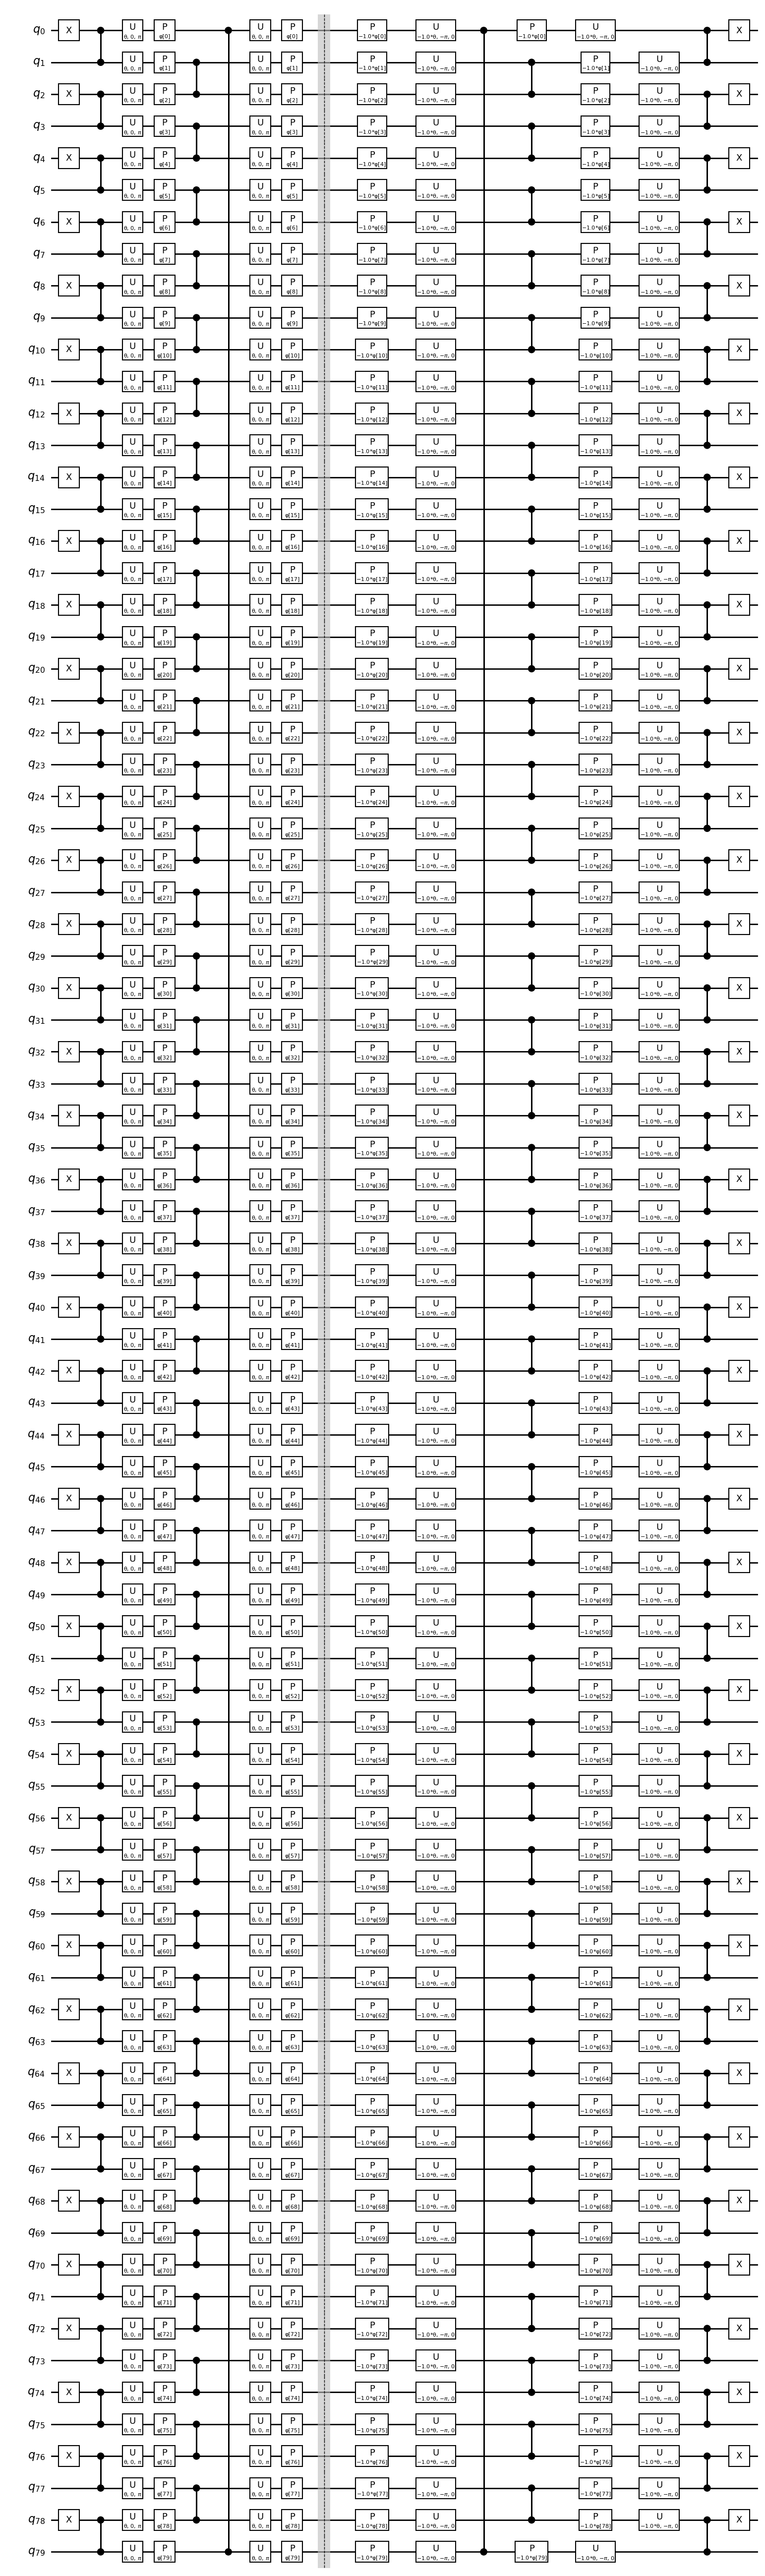

In [7]:
qc = build_compute_uncompute_mbl_circuit(num_qubits, depth, measurements=False)
qc.draw('mpl', style='bw', fold=-1)

We keep track of the 2-qubit depth of the original circuit

In [8]:
qc.depth(lambda x: x[0].num_qubits == 2)

4

We now create parameters randomly, and assign them to the circuit.

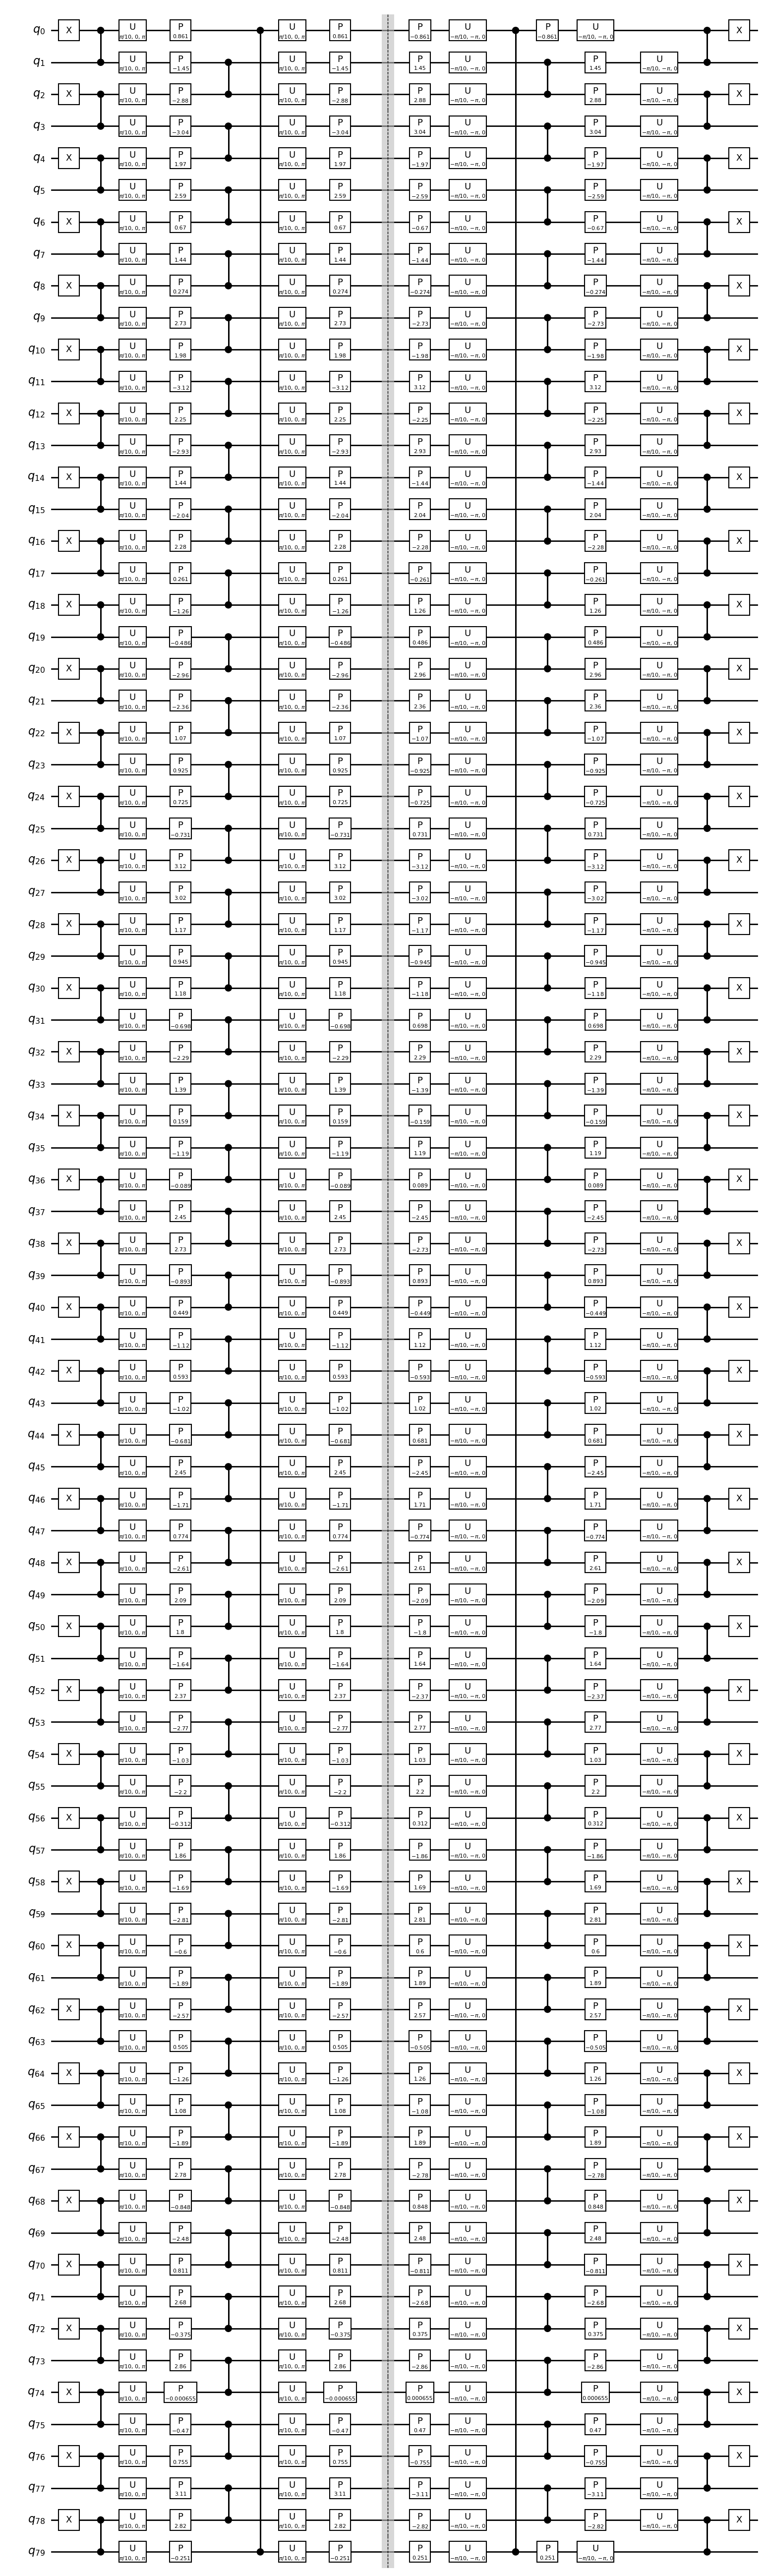

In [9]:
params = produce_mbl_parameters(0.1,num_qubits,seed=0)
theta = params[0]
phis = params[1]

parameters = [theta]
parameters.extend(phis)

qc.assign_parameters(parameters, inplace=True)
qc.draw('mpl', style='bw', fold=-1)

### 2. Optimize circuits and observables

#### Transpile the circuit

Note that transpilation can be performed at this stage, or after cutting. However, if we transpile after cutting, then we need to transpile all the subexperiments generated due to sampling over the subcircuits. Therefore, it is more prudent to transpile at this stage. However, transpilation at this stage will append multiple SWAP gates to place the periodic 2-qubit operation.

However, this problem can be avoided in this case: for this problem, we know the exact gates which will be cut. So we can create a virtual coupling map by adding virtual connections between far away qubits to accommodate these periodic 2-qubit gates. This will ensure that the circuit can be transpiled at this stage without incorporating the SWAP gates.

In [10]:
coupling_map = backend.configuration().coupling_map

virtual_coupling_map = coupling_map.copy()
virtual_coupling_map.append([init_layout[-1],init_layout[0]])
virtual_coupling_map.append([init_layout[0],init_layout[-1]])

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm_virtual = generate_preset_pass_manager(3, coupling_map=virtual_coupling_map, initial_layout=init_layout, basis_gates=backend.configuration().basis_gates)

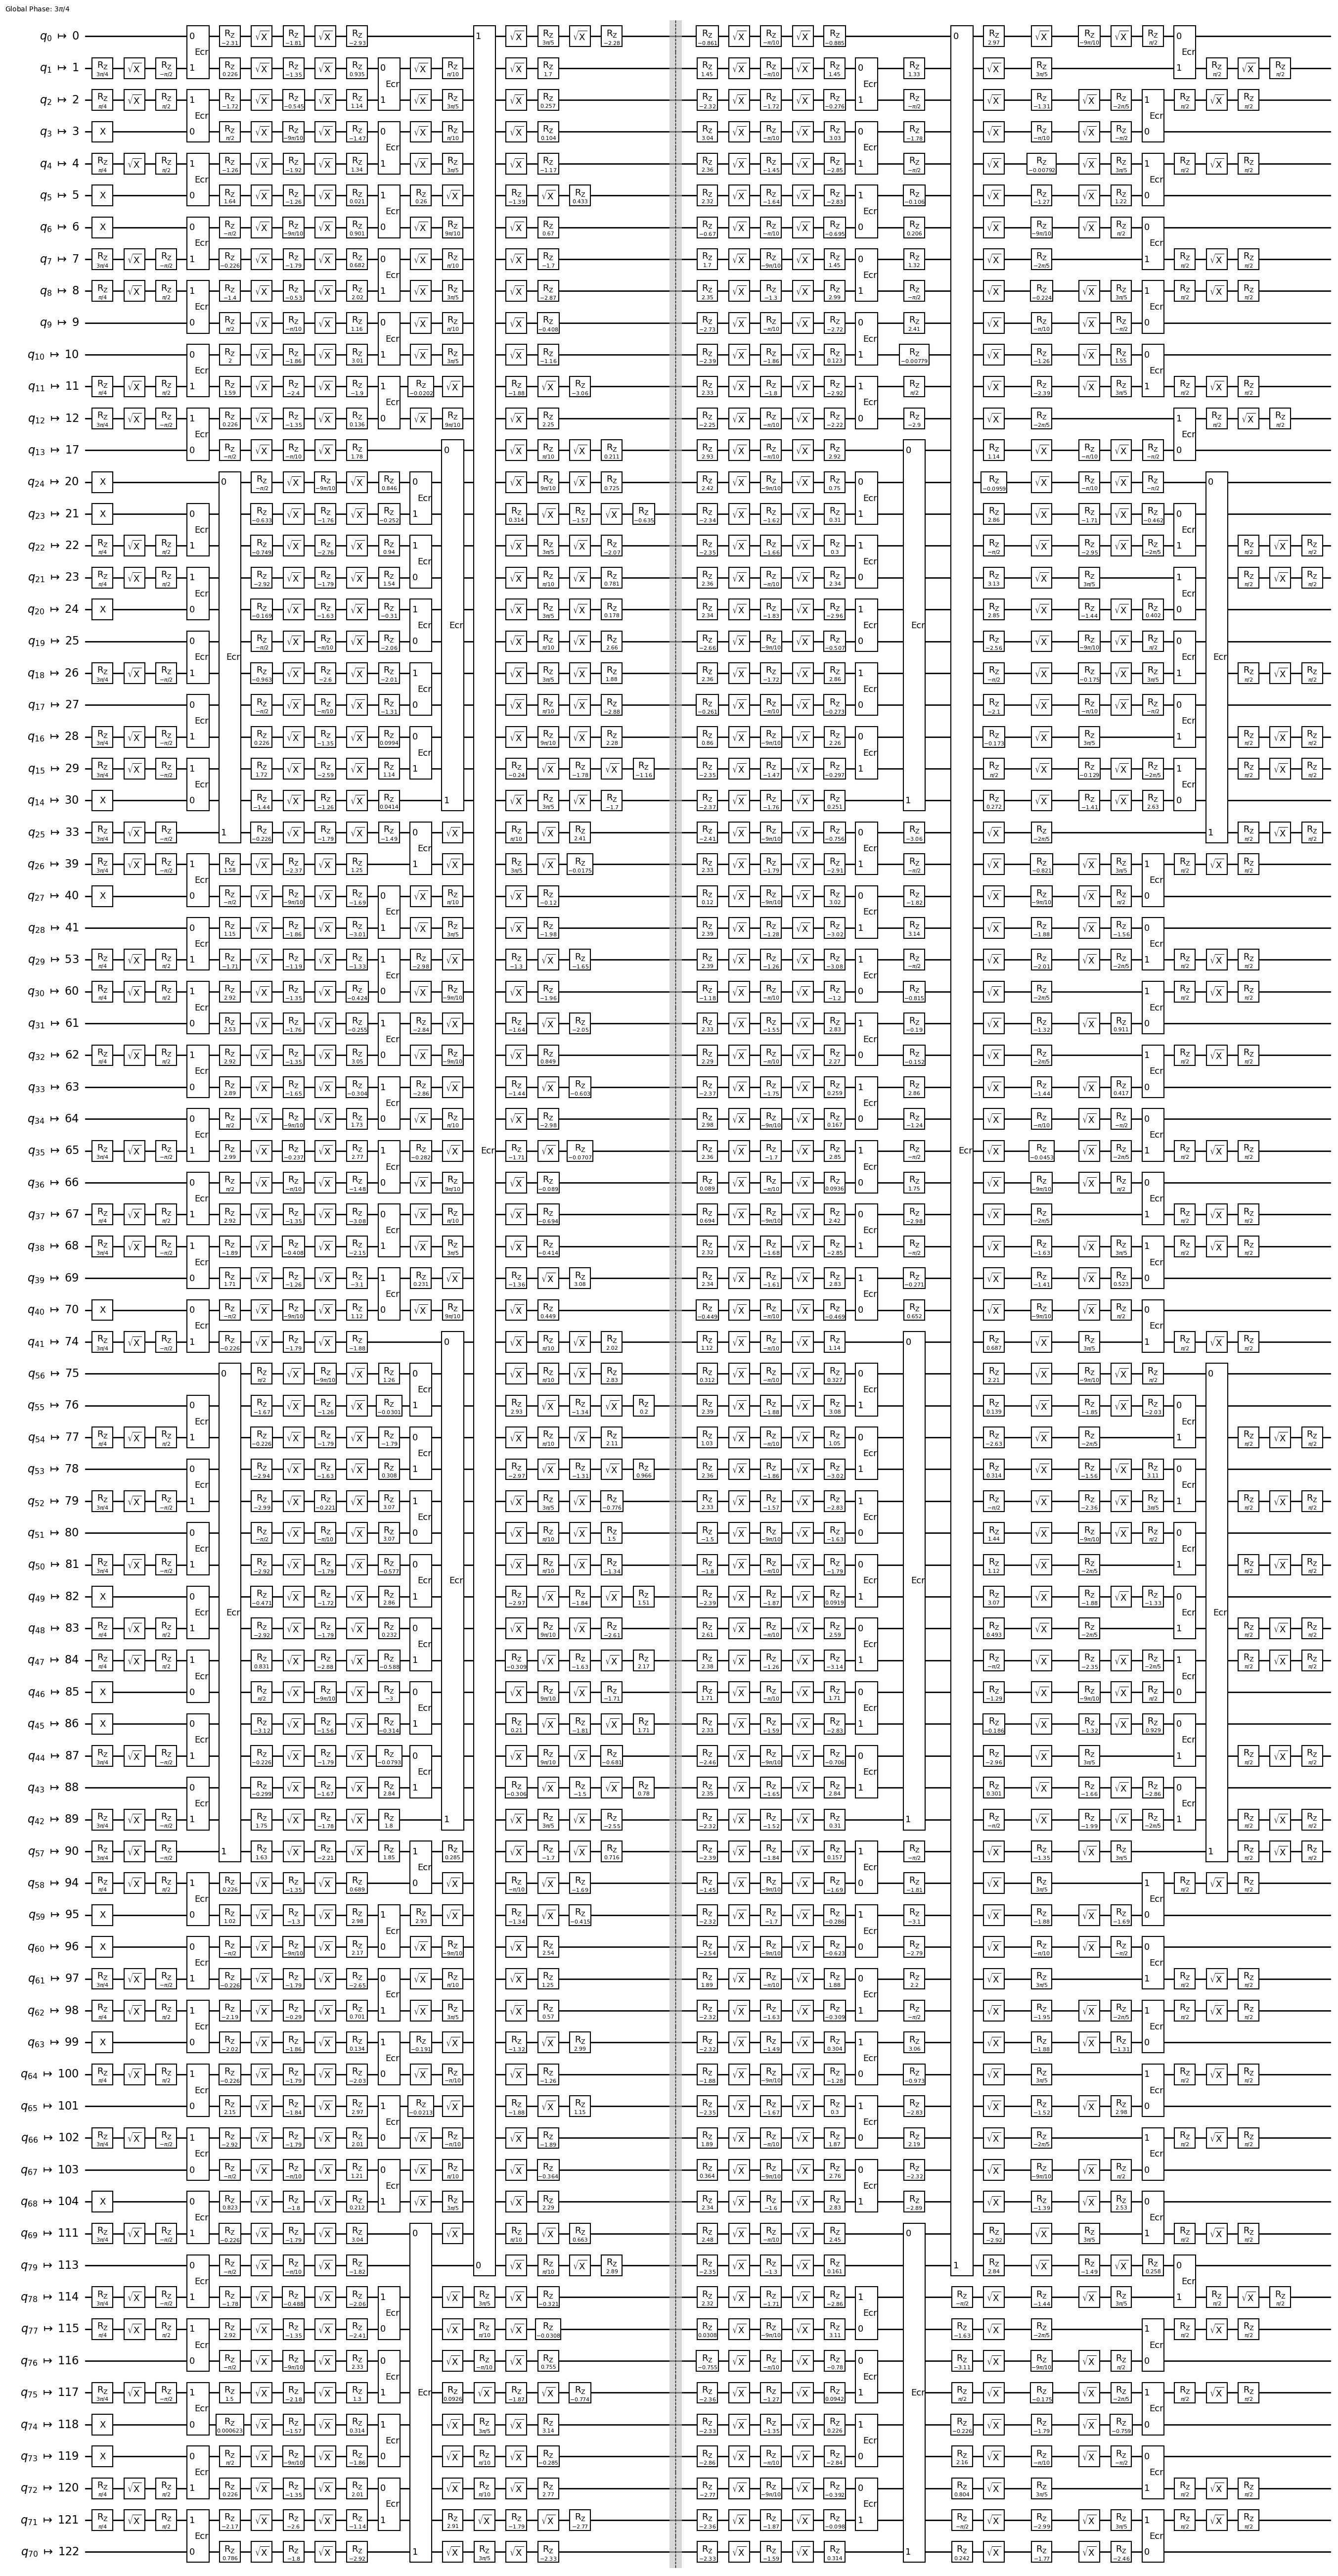

In [12]:
qc_virtual = pm_virtual.run(qc)
qc_virtual.draw('mpl', style='bw', fold=-1, idle_wires=False)

We can verify that the depth of the transpiled circuit remains the same as that of the original circuit.

In [13]:
qc_virtual.depth(lambda x:x[0].num_qubits == 2)

4

#### Select observables

We select both weight-1 and nearest neighbour weight-2 observables for this problem. The goal will be to compare the expectation values of the average of weight-1 and weight-2 observables separately.

In [14]:
observables = []

for i in range(num_qubits):
    obs = 'I'*(i)+'Z'+'I'*(num_qubits-i-1)
    observables.append(obs)

for i in range(num_qubits):
    if i == num_qubits-1:
        obs = 'Z'+'I'*(num_qubits-2) + 'Z'
    else:
        obs = 'I'*i+'ZZ'+'I'*(num_qubits-i-2)
    observables.append(obs)

Note that the transpiled circuit is a 127 qubit circuit, whereas the observables in their current form have length equal to the number of qubits in the pre-transpiled circuit. Therefore, it is necessary to expand them in accordance to the layout of the transpiled circuit.

In [15]:
from qiskit.quantum_info import SparsePauliOp, PauliList

obs = SparsePauliOp(observables).apply_layout(init_layout, num_qubits=backend.num_qubits)
paulis = obs.paulis

Now we cut the gates in the transpiled circuit. Note that the 2-qubit gates which need to be cut are the ones connecting the last and the first qubits of the layout.

In [16]:
from circuit_knitting.cutting import cut_gates, generate_cutting_experiments

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(qc_virtual.data)
    if {qc_virtual.find_bit(q)[0] for q in instruction.qubits} == {init_layout[-1],init_layout[0]}
]

Finally the subexperiments are generated by sampling over different measurement and preparation bases.

In [17]:
import numpy as np

qpd_circuit, bases = cut_gates(qc_virtual, cut_indices)
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=paulis, num_samples=np.inf
)

### 3. Execute using a Qiskit Primitive

At this point, the subexperiments contains circuits with some 1-qubit gates which are not in the basis gate set. This is because the cut qubits are measured in different basis, and the rotation gates used for this does not necessarily belong to the basis gate set. For example, measurement in X basis implies applying a Hadamard gate before the usual measurement in Z basis. But Hadamard is not a part of the basis gate set.

Instead of applying the entire transpilation process on each of the circuits in subexperiments, we can use *BasisTranslator* and then *Optimize1qGatesDecomposition* to ensure that all the gates in these circuits belong to the basis gate set. Using this method is faster than the entire transpilation process, since other steps such as routing, initial layout selection etc. are not performed again.

In [18]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator, Optimize1qGatesDecomposition
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.transpiler.passes import BasisTranslator
from qiskit.converters import circuit_to_dag, dag_to_circuit

In [19]:
pass_ = PassManager(
    [
        Optimize1qGatesDecomposition(basis=backend.configuration().basis_gates)
    ]
)

In [20]:
subexperiments = pass_.run([dag_to_circuit(
            BasisTranslator(sel, target_basis=backend.basis_gates).run(
                circuit_to_dag(circ)
            )
        )
        for circ in subexperiments])

Note that as the number of cuts increase, so does the number of circuits in subexperiments. This increase is exponential, and often we end up with more circuits than can be uploaded to the hardware as a single job. Therefore, it is prudent to break the circuit into batches of some acceptable size, run each batch of jobs, and then combine the results as a postprocessing step.

First we create an empty SamplerResult data structure to hold the final result.

In [21]:
from qiskit.primitives import SamplerResult
result_comb = SamplerResult(quasi_dists=[], metadata=[])

Now we execute the circuits in batches.

In [22]:
options = Options()
options.execution.shots = 10000
options.transpilation.skip_transpilation = True
options.resilience_level = 0

In [23]:
session = Session(backend=backend)

sampler = Sampler(session=session, options=options)

In [24]:
max_jobs = 100
idx = 0

while len(subexperiments)-idx > 1:
    if idx + max_jobs <= len(subexperiments):
        final_idx = idx + max_jobs
    else:
        final_idx = len(subexperiments)
    print(f'Starting from subexperiment id {idx} to {final_idx-1}')
    circuits = subexperiments[idx:final_idx]
    result = sampler.run(circuits).result()
    result_comb.quasi_dists.extend(result.quasi_dists)
    result_comb.metadata.extend(result.metadata)
    idx = final_idx

Starting from subexperiment id 0 to 35


### Step 4: Post process and analyze

We obtain the reconstructed expectation values.

In [25]:
from circuit_knitting.cutting import reconstruct_expectation_values

reconstructed_expvals = reconstruct_expectation_values(
    result_comb,
    coefficients,
    paulis,
)

In [26]:
print(f'Average of weight-1 expectation values is {np.mean(reconstructed_expvals[:num_qubits])}')
print(f'Average of weight-2 expectation values is {np.mean(reconstructed_expvals[num_qubits:])}')

Average of weight-1 expectation values is 0.8567556249999246
Average of weight-2 expectation values is 0.7613437499999354


### Cross Verify

It is useful to cross-verify the technique against uncut. For that we shall execute the uncut circuit on the backend and calculate the average of weight-1 and weight-2 observables separately. Note that since this is a compute-uncompute circuit, the ideal value for both the observables should be 1. Circuit-knitting-toolbox requires circuits without measurements. For experiment with the uncut circuit, we append the measurement and run it on Sampler. Note that we could have run on estimator as well.

In [27]:
pm_uncut = generate_preset_pass_manager(3, backend, initial_layout=init_layout)

if qc.num_clbits == 0:
    qc.measure_all()

trans_qc = pm_uncut.run(qc)

In [28]:
uncut_result = sampler.run(trans_qc).result()

In [29]:
uncut_counts = uncut_result.quasi_dists[0].binary_probabilities()

Now we shall calculate the expectation values of all the observables separately

In [30]:
from qiskit.result import sampled_expectation_value

uncut_expvals = [sampled_expectation_value(uncut_counts, obs) for obs in observables]

In [31]:
print(f'Average of weight-1 expectation values is {np.mean(uncut_expvals[:num_qubits])}')
print(f'Average of weight-2 expectation values is {np.mean(uncut_expvals[num_qubits:])}')

Average of weight-1 expectation values is 0.4723149999999512
Average of weight-2 expectation values is 0.27951999999997473
